# Advanced Netflix Viewing History Analysis

This notebook reads and cleans your Netflix viewing history, parses titles into series/season/episode, adds temporal features, and runs multiple in‐depth analytical functions.

## 1. Setup & Title Parsing

In [13]:
import pandas as pd

# Skip first line ("ViewingActivity")
df_raw = pd.read_csv('ViewingActivity.csv', sep=';', header=1, encoding='utf-8')

print("Columns:", df_raw.columns.tolist())
display(df_raw.head())


Columns: ['Profile Name', 'Start Time', 'Duration', 'Attributes', 'Title', 'Supplemental Video Type', 'Device Type', 'Bookmark', 'Latest Bookmark', 'Country']


,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,begüm,2025-05-26 22:58:45,00:21:42,NaN,Brooklyn Nine-Nine: Season 2: The Mole (Episod...,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:21:42,00:21:42,TR (Turkey)
1,begüm,2025-05-26 22:36:59,00:21:42,NaN,Brooklyn Nine-Nine: Season 2: Halloween II (Ep...,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:21:42,00:21:42,TR (Turkey)
2,begüm,2025-05-26 22:36:36,00:00:11,Autoplayed: user action: User_Interaction;,Brooklyn Nine-Nine: Season 1 - CLM 12,HOOK,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:00:11,00:00:11,TR (Turkey)
3,begüm,2025-05-26 19:43:23,00:00:06,Autoplayed: user action: None;,The Fall: Series 1_hook_primary_16x9,HOOK,Safari MAC (Cadmium),00:00:06,00:00:06,TR (Turkey)
4,begüm,2025-05-26 15:47:35,00:59:26,Autoplayed: user action: User_Interaction;,Sirens: Limited Series: Siren Song (Episode 5),NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:59:51,00:59:51,TR (Turkey)


Clean & Feature-Engineer ViewingActivity


In [14]:
import pandas as pd
import re

# 1. Load the CSV (skip dummy first line)
df = pd.read_csv('ViewingActivity.csv', sep=';', header=1, encoding='utf-8')

# 2. Filter for your profile
df = df[df['Profile Name'].str.lower() == 'begüm'].copy()

# 3. Parse timestamp and duration
df['timestamp']    = pd.to_datetime(df['Start Time'], format='%Y-%m-%d %H:%M:%S')
df['duration_min'] = pd.to_timedelta(df['Duration']).dt.total_seconds() / 60

# 4. Extract date, hour, day_of_week
df['date']        = df['timestamp'].dt.date
df['hour']        = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# 5. Robust Title parsing into Series / Season / Episode
def parse_title(t):
    """
    Extract Series name, Season number, and Episode title.
    Matches patterns like:
      "Show Name: Season 2: Episode Title"
      "Show Name - Series 1 - Episode Title"
      "Show Name: Series 1_hook_primary_16x9"
    Falls back to Movie if no season/series found.
    """
    pat = re.compile(
        r'^(.*?)\s*[:\-\|]\s*'                 # Series name + delim
        r'(?:Season|Series)\s*(\d+)\s*'        # "Season" or "Series" + number
        r'[:\-\|_\s]+\s*(.+)$',                # delim + Episode
        flags=re.IGNORECASE
    )
    m = pat.match(t)
    if m:
        series = m.group(1).strip()
        season = m.group(2)
        episode = m.group(3).strip()
    else:
        # No season/series pattern → treat as Movie
        series = t
        season = 'Movie'
        episode = t
    return pd.Series([series, season, episode], index=['Series','Season','Episode'])

splits = df['Title'].apply(parse_title)
splits['Season'] = splits['Season'].astype('category')

# 6. Consolidate into final cleaned DataFrame
df_clean = pd.concat([
    df.drop(columns=['Profile Name','Start Time','Duration','Title']),
    splits
], axis=1).reset_index(drop=True)

# 7. Preview results
print("Cleaned DataFrame columns:", df_clean.columns.tolist())
df_clean.head(50)


Cleaned DataFrame columns: ['Attributes', 'Supplemental Video Type', 'Device Type', 'Bookmark', 'Latest Bookmark', 'Country', 'timestamp', 'duration_min', 'date', 'hour', 'day_of_week', 'Series', 'Season', 'Episode']


,Attributes,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country,timestamp,duration_min,date,hour,day_of_week,Series,Season,Episode
0,NaN,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:21:42,00:21:42,TR (Turkey),2025-05-26 22:58:45,21.700000,2025-05-26,22,Monday,Brooklyn Nine-Nine,2,The Mole (Episode 5)
1,NaN,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:21:42,00:21:42,TR (Turkey),2025-05-26 22:36:59,21.700000,2025-05-26,22,Monday,Brooklyn Nine-Nine,2,Halloween II (Episode 4)
2,Autoplayed: user action: User_Interaction;,HOOK,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:00:11,00:00:11,TR (Turkey),2025-05-26 22:36:36,0.183333,2025-05-26,22,Monday,Brooklyn Nine-Nine,1,CLM 12
3,Autoplayed: user action: None;,HOOK,Safari MAC (Cadmium),00:00:06,00:00:06,TR (Turkey),2025-05-26 19:43:23,0.100000,2025-05-26,19,Monday,The Fall,1,hook_primary_16x9
4,Autoplayed: user action: User_Interaction;,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:59:51,00:59:51,TR (Turkey),2025-05-26 15:47:35,59.433333,2025-05-26,15,Monday,Sirens: Limited Series: Siren Song (Episode 5),Movie,Sirens: Limited Series: Siren Song (Episode 5)
5,Autoplayed: user action: User_Interaction;,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:48:24,00:48:24,TR (Turkey),2025-05-26 14:59:08,48.333333,2025-05-26,14,Monday,Sirens: Limited Series: Persephone (Episode 4),Movie,Sirens: Limited Series: Persephone (Episode 4)
6,Autoplayed: user action: User_Interaction;,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:50:22,00:50:22,TR (Turkey),2025-05-26 14:37:08,21.883333,2025-05-26,14,Monday,Sirens: Limited Series: Monster (Episode 3),Movie,Sirens: Limited Series: Monster (Episode 3)
7,Autoplayed: user action: None;,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:28:32,Not latest view,TR (Turkey),2025-05-26 12:50:23,16.433333,2025-05-26,12,Monday,Sirens: Limited Series: Monster (Episode 3),Movie,Sirens: Limited Series: Monster (Episode 3)
8,Autoplayed: user action: User_Interaction;,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:33:50,Not latest view,TR (Turkey),2025-05-26 01:00:57,35.016667,2025-05-26,1,Monday,Sirens: Limited Series: Monster (Episode 3),Movie,Sirens: Limited Series: Monster (Episode 3)
9,NaN,NaN,Vestel RefPlus-Vestel-4K-T32 Smart TV,00:51:06,00:51:06,TR (Turkey),2025-05-26 00:13:28,42.516667,2025-05-26,0,Monday,Sirens: Limited Series: Talons (Episode 2),Movie,Sirens: Limited Series: Talons (Episode 2)


In [15]:
# I’ll store the calendar-based season in a new column 'SeasonBin'

def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Extract month
df_clean['Month'] = df_clean['timestamp'].dt.month

# Create calendar-based season
df_clean['SeasonBin'] = df_clean['Month'].apply(month_to_season).astype('category')

# Preview the distinction
display(df_clean[['Series','Season','Month','SeasonBin']].head(10))


,Series,Season,Month,SeasonBin
0,Brooklyn Nine-Nine,2,5,Spring
1,Brooklyn Nine-Nine,2,5,Spring
2,Brooklyn Nine-Nine,1,5,Spring
3,The Fall,1,5,Spring
4,Sirens: Limited Series: Siren Song (Episode 5),Movie,5,Spring
5,Sirens: Limited Series: Persephone (Episode 4),Movie,5,Spring
6,Sirens: Limited Series: Monster (Episode 3),Movie,5,Spring
7,Sirens: Limited Series: Monster (Episode 3),Movie,5,Spring
8,Sirens: Limited Series: Monster (Episode 3),Movie,5,Spring
9,Sirens: Limited Series: Talons (Episode 2),Movie,5,Spring


## 3. Viewing Trends Over Time

<ipython-input-16-bf79abc47a3a>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly.index, y=hourly.values, palette=pink_palette)
<ipython-input-16-bf79abc47a3a>:48: UserWarning: 
The palette list has fewer values (5) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=hourly.index, y=hourly.values, palette=pink_palette)


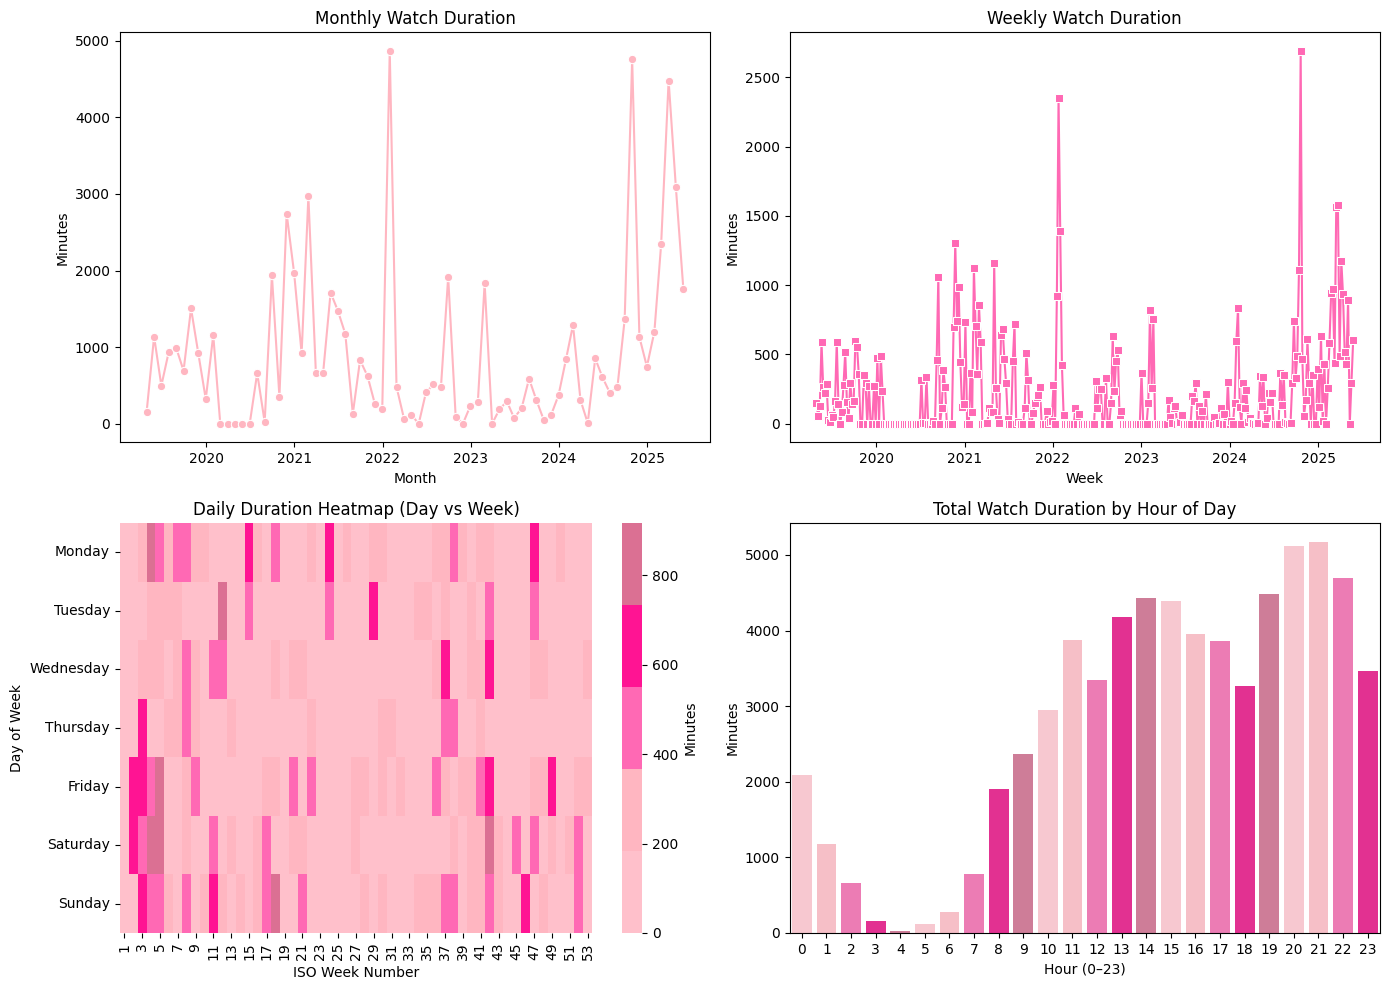

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pink_palette = ['#FFC0CB','#FFB6C1','#FF69B4','#FF1493','#DB7093']

# 1) Resample your duration series
ts      = df_clean.set_index('timestamp')['duration_min']
monthly = ts.resample('ME').sum()
weekly  = ts.resample('W-MON').sum()
daily   = ts.resample('D').sum()
hourly  = df_clean.groupby('hour')['duration_min'].sum()

# 2) Build a daily DataFrame for the heatmap
daily_df = (
    daily
    .reset_index(name='duration_min')
    .assign(
        week=lambda d: d['timestamp'].dt.isocalendar().week,
        dow =lambda d: d['timestamp'].dt.day_name()
    )
)

pivot = daily_df.pivot_table(
    index='dow',
    columns='week',
    values='duration_min',
    aggfunc='sum'
).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# 3) Plot
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
sns.lineplot(x=monthly.index, y=monthly.values, marker='o', color=pink_palette[1])
plt.title('Monthly Watch Duration'); plt.ylabel('Minutes'); plt.xlabel('Month')

plt.subplot(2,2,2)
sns.lineplot(x=weekly.index, y=weekly.values, marker='s', color=pink_palette[2])
plt.title('Weekly Watch Duration'); plt.ylabel('Minutes'); plt.xlabel('Week')

plt.subplot(2,2,3)
sns.heatmap(pivot, cmap=pink_palette, cbar_kws={'label':'Minutes'})
plt.title('Daily Duration Heatmap (Day vs Week)')
plt.xlabel('ISO Week Number'); plt.ylabel('Day of Week')

plt.subplot(2,2,4)
sns.barplot(x=hourly.index, y=hourly.values, palette=pink_palette)
plt.title('Total Watch Duration by Hour of Day')
plt.xlabel('Hour (0–23)'); plt.ylabel('Minutes')

plt.tight_layout()
plt.show()


## 4. Series Watching Patterns

<ipython-input-17-e6c3072af83d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series_counts.values, y=series_counts.index, palette=pink_palette)
<ipython-input-17-e6c3072af83d>:17: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=series_counts.values, y=series_counts.index, palette=pink_palette)
<ipython-input-17-e6c3072af83d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Season', data=df_clean[df_clean['ContentType']=='Series'],
<ipython-input-17-e6c3072af83d>:24: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpreta

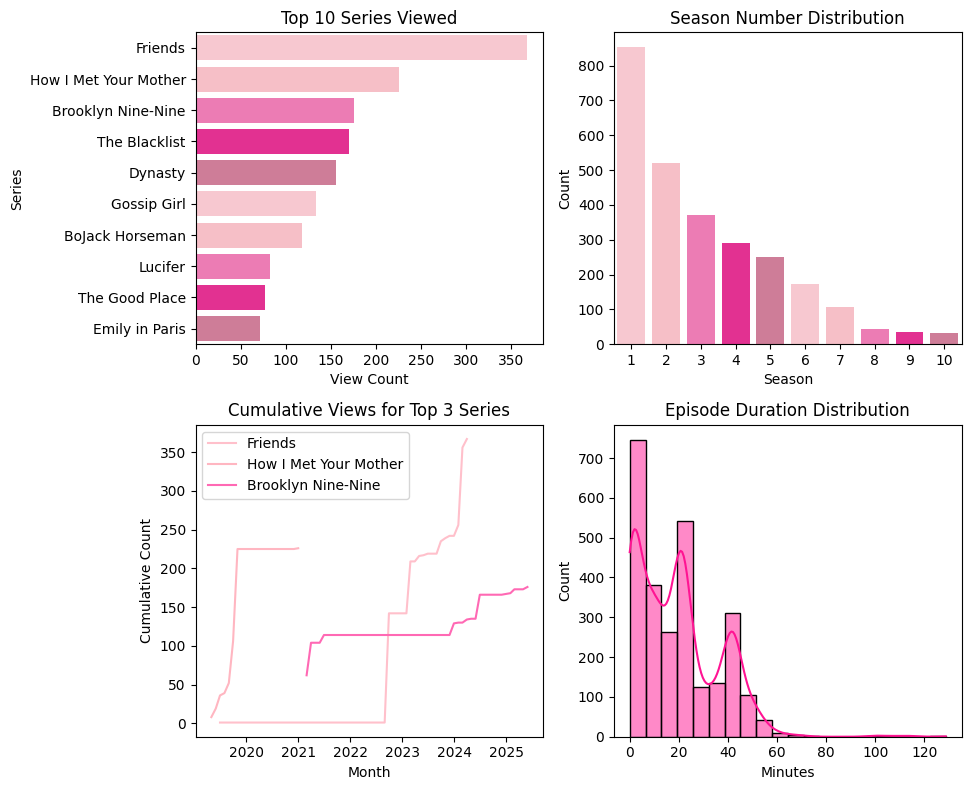

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure ContentType exists
if 'ContentType' not in df_clean:
    df_clean['ContentType'] = np.where(df_clean['Season']=='Movie', 'Movie', 'Series')

# Pink palette
pink_palette = ['#FFC0CB','#FFB6C1','#FF69B4','#FF1493','#DB7093']

plt.figure(figsize=(14,8))

# 1) Top 10 Series by view count
plt.subplot(2,3,1)
series_counts = df_clean[df_clean['ContentType']=='Series']['Series'].value_counts().head(10)
sns.barplot(x=series_counts.values, y=series_counts.index, palette=pink_palette)
plt.title('Top 10 Series Viewed')
plt.xlabel('View Count'); plt.ylabel('Series')

# 2) Season distribution among series
plt.subplot(2,3,2)
season_order = sorted(df_clean[df_clean['ContentType']=='Series']['Season'].unique().tolist(), key=lambda x: (x=='Movie', int(x) if x.isdigit() else 0))
sns.countplot(x='Season', data=df_clean[df_clean['ContentType']=='Series'],
              order=season_order, palette=pink_palette)
plt.title('Season Number Distribution')
plt.xlabel('Season'); plt.ylabel('Count')

# 3) Episode duration distribution (series only)
plt.subplot(2,3,5)
sns.histplot(
    df_clean.loc[df_clean['ContentType']=='Series', 'duration_min'],
    bins=20, kde=True, color=pink_palette[3]
)
plt.title('Episode Duration Distribution')
plt.xlabel('Minutes'); plt.ylabel('Count')

# 4) Cumulative Series Views over time for top 3
plt.subplot(2,3,4)
top3 = series_counts.index[:3]
for s, color in zip(top3, pink_palette[:3]):
    sub = (
        df_clean[df_clean['Series']==s]
        .set_index('timestamp')
        .resample('ME')['Series']
        .size()
        .cumsum()
    )
    sns.lineplot(x=sub.index, y=sub.values, label=s, color=color)
plt.title('Cumulative Views for Top 3 Series')
plt.xlabel('Month'); plt.ylabel('Cumulative Count')
plt.legend()



plt.tight_layout()
plt.show()


## 5. Movie vs Series Distribution

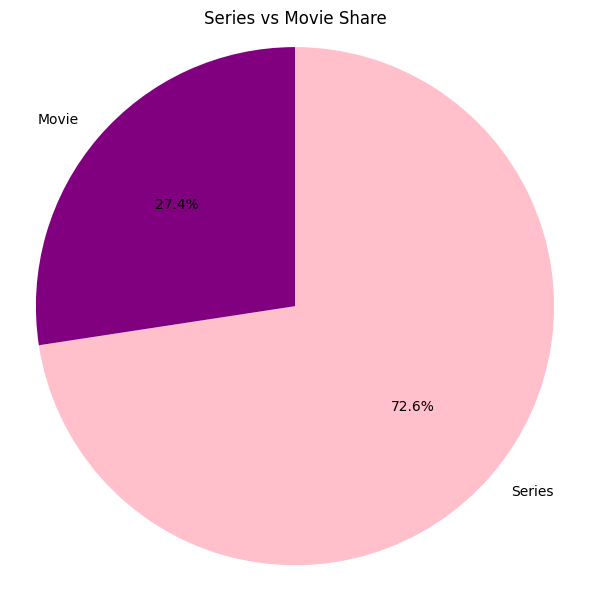

In [18]:
import matplotlib.pyplot as plt

# Prepare counts
ct = df_clean['ContentType'].value_counts()
labels = ct.index.tolist()
sizes  = ct.values.tolist()

# Define colors: first pink, second purple
colors = [pink_palette[0], 'purple'][:len(sizes)]

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    counterclock=False
)
plt.title('Series vs Movie Share')
plt.axis('equal')  # draw as a circle
plt.tight_layout()
plt.show()


## 6. Binge Watching Patterns

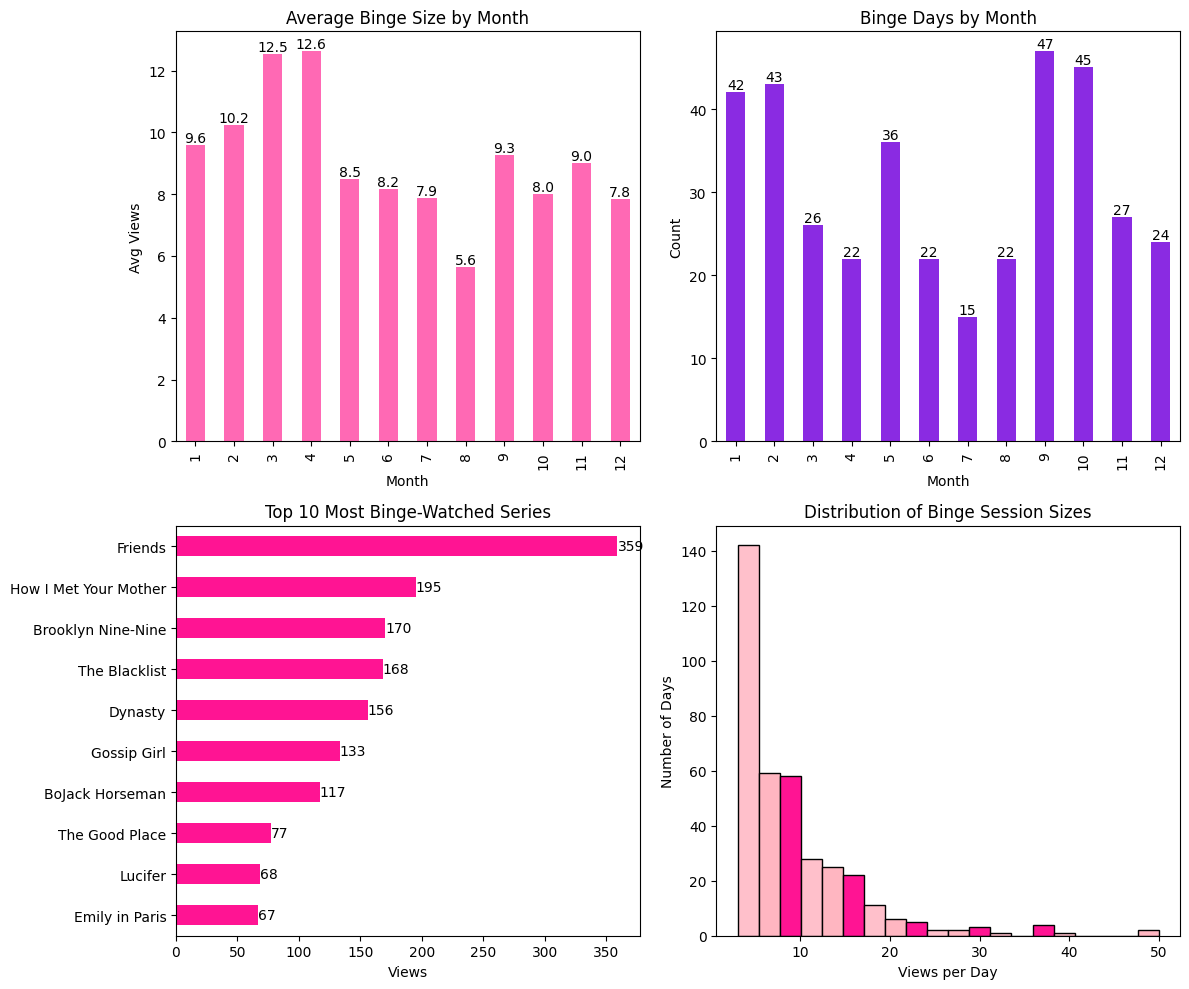

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pink & purple palette
pink = '#FF69B4'
purple = '#8A2BE2'
other_pinks = ['#FFC0CB', '#FFB6C1', '#FF1493']  # for later use

def analyze_binge_patterns_annotated(df):
    df['DateOnly'] = pd.to_datetime(df['timestamp'].dt.date)
    groups = df.groupby('DateOnly')
    binge_days = groups.size().loc[lambda s: s >= 3]
    binge_content = groups['Series'].apply(list).loc[binge_days.index]

    monthly_binges = (
        binge_days
        .groupby(binge_days.index.to_series().dt.month)
        .agg(['mean','count'])
        .rename(columns={'mean':'AvgBingeSize','count':'BingeDayCount'})
    )
    top_binged = (
        pd.Series([s for sub in binge_content for s in sub])
        .value_counts()
        .head(10)
    )

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # 1) Avg binge size by month with pink bars + annotations
    ax = axs[0,0]
    bars = monthly_binges['AvgBingeSize'].plot(
        kind='bar', ax=ax, color=pink, title='Average Binge Size by Month'
    )
    ax.set_xlabel('Month'); ax.set_ylabel('Avg Views')
    for p in bars.patches:
        ax.annotate(f"{p.get_height():.1f}",
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')

    # 2) Binge days count by month with purple bars + annotations
    ax = axs[0,1]
    bars = monthly_binges['BingeDayCount'].plot(
        kind='bar', ax=ax, color=purple, title='Binge Days by Month'
    )
    ax.set_xlabel('Month'); ax.set_ylabel('Count')
    for p in bars.patches:
        ax.annotate(f"{int(p.get_height())}",
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')

    # 3) Top binge series, horizontal bar with a darker pink
    ax = axs[1,0]
    bars = top_binged.plot(
        kind='barh', ax=ax, color=other_pinks[2], title='Top 10 Most Binge-Watched Series'
    )
    ax.invert_yaxis()
    ax.set_xlabel('Views')
    for p in bars.patches:
        ax.annotate(f"{int(p.get_width())}",
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center')

    # 4) Distribution of binge sizes: gradient of pinks
    ax = axs[1,1]
    counts, bins, patches = ax.hist(
        binge_days.values, bins=20, edgecolor='black'
    )
    ax.set_title('Distribution of Binge Session Sizes')
    ax.set_xlabel('Views per Day'); ax.set_ylabel('Number of Days')
    cmap = sns.color_palette(other_pinks, n_colors=len(patches))
    for patch, color in zip(patches, cmap):
        patch.set_facecolor(color)

    plt.tight_layout()
    return monthly_binges, top_binged

# Execute & show
monthly_binges, top_binged = analyze_binge_patterns_annotated(df_clean)


## 7. Seasonal Viewing Patterns

<ipython-input-27-8a7910f5b80c>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_counts   = df_clean.groupby('SeasonBin').size()
<ipython-input-27-8a7910f5b80c>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_duration = df_clean.groupby('SeasonBin')['duration_min'].sum()
<ipython-input-27-8a7910f5b80c>:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  season_ct_dist  = df_clean.pivot_table(
<ipython-input-27-8a7910f5b80c>:20: Futur

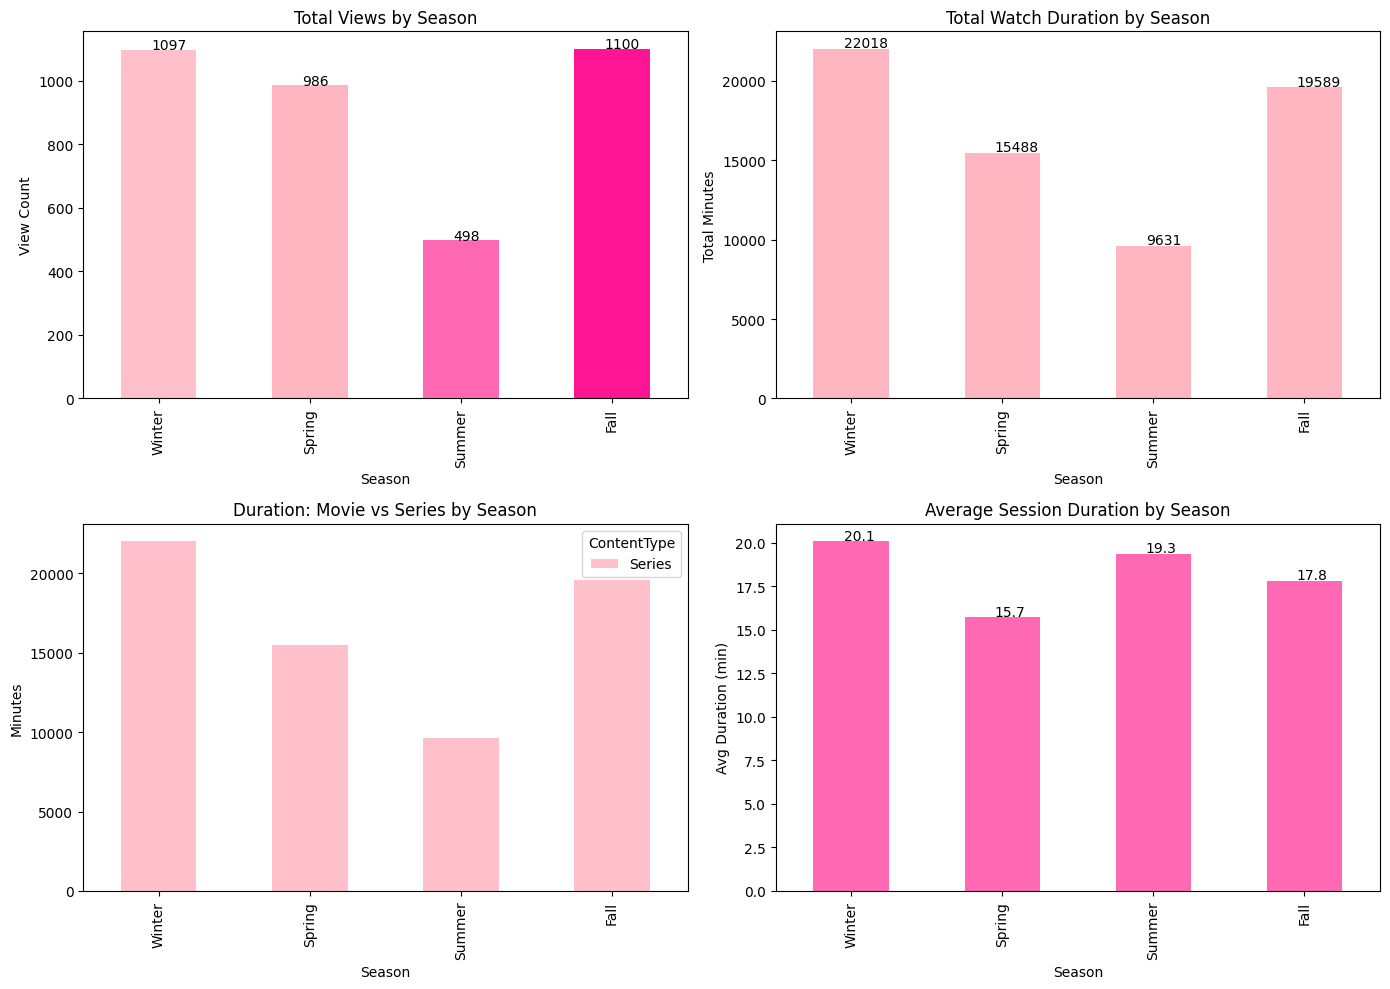

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pink palette
pink_palette = ['#FFC0CB','#FFB6C1','#FF69B4','#FF1493','#DB7093']

# Ensure SeasonBin and ContentType exist
if 'SeasonBin' not in df_clean:
    df_clean['SeasonBin'] = df_clean['timestamp'].dt.month.apply(month_to_season).astype('category')
if 'ContentType' not in df_clean:
    df_clean['ContentType'] = np.where(df_clean['Season']=='Movie', 'Movie', 'Series')

# Aggregate metrics
season_counts   = df_clean.groupby('SeasonBin').size()
season_duration = df_clean.groupby('SeasonBin')['duration_min'].sum()
season_ct_dist  = df_clean.pivot_table(
    index='SeasonBin', columns='ContentType', values='duration_min', aggfunc='sum', fill_value=0
)
season_avg_dur  = df_clean.groupby('SeasonBin')['duration_min'].mean()

fig, axs = plt.subplots(2, 2, figsize=(14,10))

# 1) Total views by season (bar)
ax = axs[0,0]
bars = season_counts.reindex(['Winter','Spring','Summer','Fall']).plot(
    kind='bar', ax=ax, color=pink_palette[:4], title='Total Views by Season'
)
ax.set_xlabel('Season'); ax.set_ylabel('View Count')
for p in bars.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.2, p.get_height()+1))

# 2) Total watch duration by season (bar)
ax = axs[0,1]
bars = season_duration.reindex(['Winter','Spring','Summer','Fall']).plot(
    kind='bar', ax=ax, color=pink_palette[1], title='Total Watch Duration by Season'
)
ax.set_xlabel('Season'); ax.set_ylabel('Total Minutes')
for p in bars.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+0.2, p.get_height()+100))

# 3) ContentType distribution by season (stacked bar)
ax = axs[1,0]
season_ct_dist.reindex(['Winter','Spring','Summer','Fall']).plot(
    kind='bar', stacked=True, ax=ax, color=pink_palette[:2], title='Duration: Movie vs Series by Season'
)
ax.set_xlabel('Season'); ax.set_ylabel('Minutes'); ax.legend(title='ContentType')

# 4) Average session duration by season (bar)
ax = axs[1,1]
bars = season_avg_dur.reindex(['Winter','Spring','Summer','Fall']).plot(
    kind='bar', ax=ax, color=pink_palette[2], title='Average Session Duration by Season'
)
ax.set_xlabel('Season'); ax.set_ylabel('Avg Duration (min)')
for p in bars.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x()+0.2, p.get_height()+0.1))

plt.tight_layout()
plt.show()


## 8. Correlation & Trend Analysis

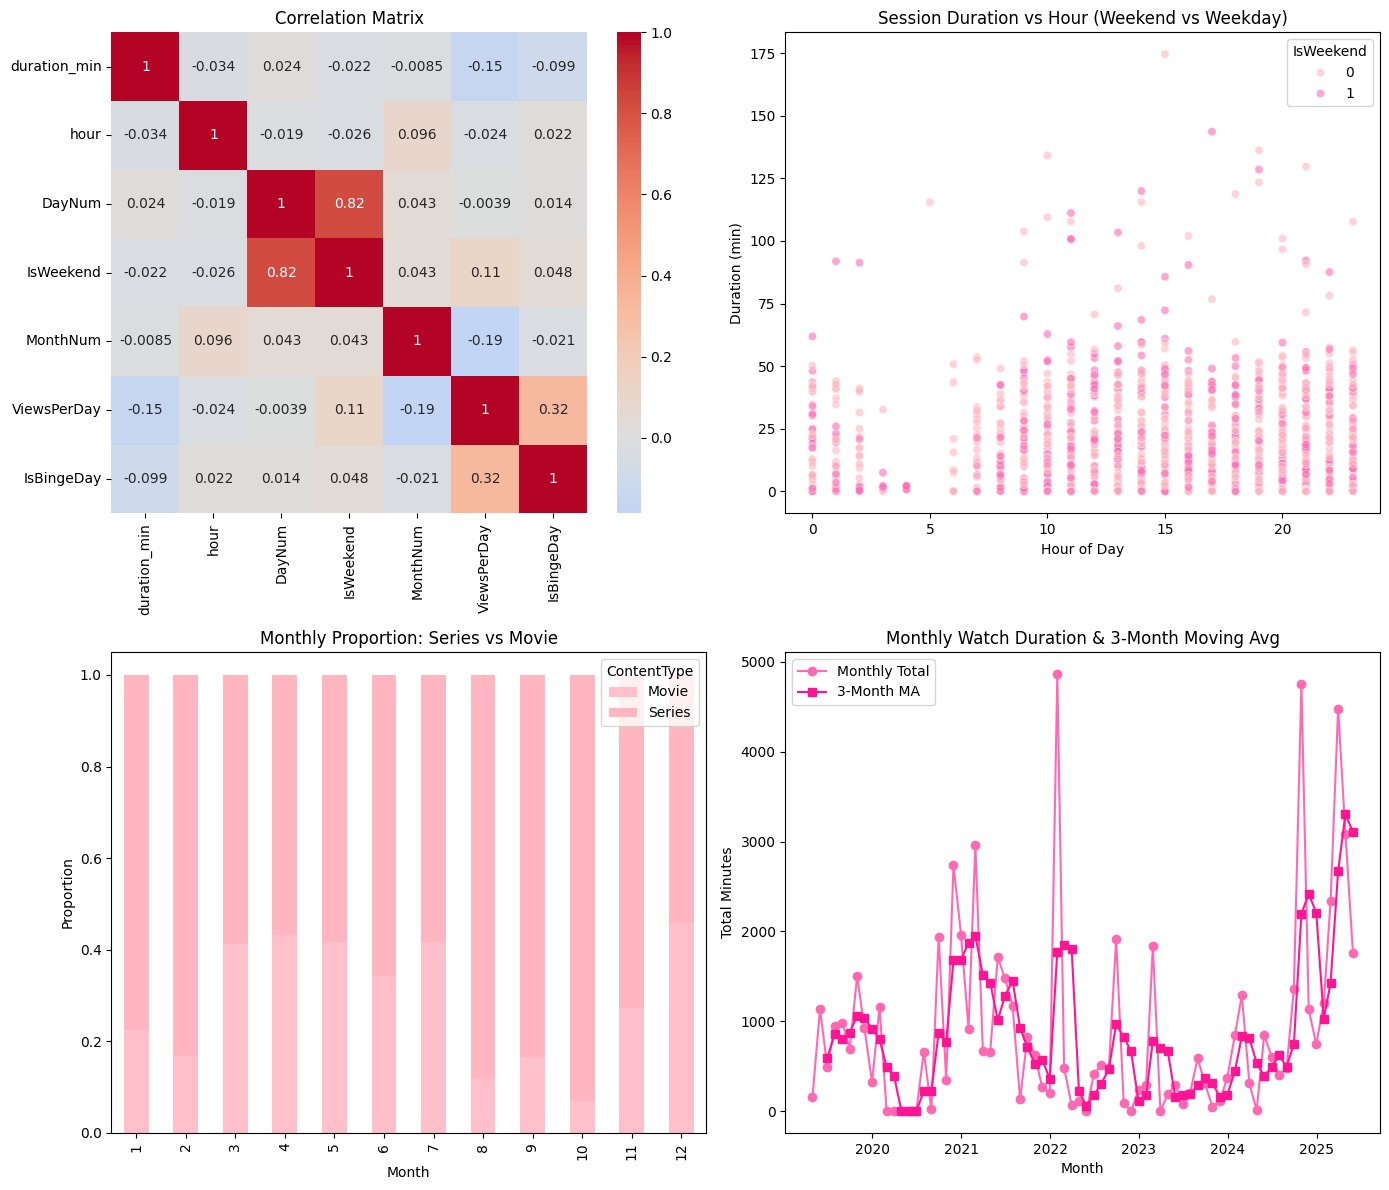

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pink palette
pink_palette = ['#FFC0CB','#FFB6C1','#FF69B4','#FF1493','#DB7093']

# Prepare analysis DataFrame
adv = df_clean.copy()
adv['hour']         = adv['timestamp'].dt.hour
adv['DayNum']       = adv['timestamp'].dt.dayofweek
adv['IsWeekend']    = adv['DayNum'].isin([5,6]).astype(int)
adv['MonthNum']     = adv['timestamp'].dt.month
adv['ViewsPerDay']  = adv.groupby(adv['timestamp'].dt.date)['Series'].transform('count')
adv['IsBingeDay']   = (adv['ViewsPerDay'] >= 3).astype(int)

# 1) Correlation matrix of numeric features
features = ['duration_min','hour','DayNum','IsWeekend','MonthNum','ViewsPerDay','IsBingeDay']
corr = adv[features].corr()

# 2) Monthly ratio of Series vs Movie (by count)
ratio_monthly = (
    adv
    .groupby([adv['MonthNum'], 'ContentType'])
    .size()
    .unstack(fill_value=0)
)
ratio_monthly = ratio_monthly.div(ratio_monthly.sum(axis=1), axis=0)

# 3) Rolling monthly total duration (3-month)
monthly_sum = adv.set_index('timestamp')['duration_min'].resample('ME').sum()
rolling3    = monthly_sum.rolling(3).mean()

fig, axs = plt.subplots(2, 2, figsize=(14,12))

# A) Correlation heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=axs[0,0])
axs[0,0].set_title('Correlation Matrix')

# B) Duration vs Hour, colored by weekend
sns.scatterplot(
    x='hour', y='duration_min', hue='IsWeekend',
    data=adv.sample(min(len(adv), 2000)),
    palette=[pink_palette[1], pink_palette[2]],
    alpha=0.6, ax=axs[0,1]
)
axs[0,1].set_title('Session Duration vs Hour (Weekend vs Weekday)')
axs[0,1].set_xlabel('Hour of Day'); axs[0,1].set_ylabel('Duration (min)')

# C) Monthly proportion Series vs Movie
ratio_monthly.reindex(range(1,13)).plot(
    kind='bar', stacked=True,
    color=[pink_palette[0], pink_palette[1]],
    ax=axs[1,0]
)
axs[1,0].set_title('Monthly Proportion: Series vs Movie')
axs[1,0].set_xlabel('Month'); axs[1,0].set_ylabel('Proportion')
axs[1,0].legend(title='ContentType')

# D) Rolling trend of monthly duration
axs[1,1].plot(monthly_sum.index, monthly_sum.values, marker='o', color=pink_palette[2], label='Monthly Total')
axs[1,1].plot(rolling3.index,   rolling3.values,   marker='s', color=pink_palette[3], label='3-Month MA')
axs[1,1].set_title('Monthly Watch Duration & 3-Month Moving Avg')
axs[1,1].set_xlabel('Month'); axs[1,1].set_ylabel('Total Minutes')
axs[1,1].legend()

plt.tight_layout()
plt.show()


Hypothesis Testing

I framed my tests around the idea that Netflix viewing behavior—whether measured by daily view counts, binge-watch frequency, or total session duration—would differ between weekends and weekdays and also vary seasonally (e.g. winter vs. summer), and then used t-tests and a χ² test to evaluate those specific null hypotheses.

In [28]:
import pandas as pd
from scipy import stats

# Prepare analysis DataFrame
adv = df_clean.copy()
adv['DateOnly']    = adv['timestamp'].dt.date
adv['hour']        = adv['timestamp'].dt.hour
adv['DayNum']      = adv['timestamp'].dt.dayofweek
adv['IsWeekend']   = adv['DayNum'].isin([5,6]).astype(int)
adv['ViewsPerDay'] = adv.groupby(adv['DateOnly'])['Series'].transform('count')
adv['IsBingeDay']  = (adv['ViewsPerDay'] >= 3).astype(int)

# 1) Weekend vs Weekday daily counts
daily = adv.groupby('DateOnly').agg({
    'ViewsPerDay': 'first',
    'IsWeekend':   'first'
}).reset_index(drop=True)

wknd = daily.loc[daily['IsWeekend']==1, 'ViewsPerDay']
wday = daily.loc[daily['IsWeekend']==0, 'ViewsPerDay']
t1, p1 = stats.ttest_ind(wknd, wday, equal_var=False)
print(f"Weekend vs Weekday Views: t = {t1:.2f}, p = {p1:.4f}")
print("→", "Significant difference" if p1<0.05 else "No significant difference")

# 2) Winter vs Summer binge rates
adv['SeasonBin'] = adv['timestamp'].dt.month.apply(month_to_season)
binge = adv.groupby('DateOnly').agg({
    'ViewsPerDay': 'first',
    'SeasonBin':   'first',
}).reset_index(drop=True)
binge['IsBinge'] = (binge['ViewsPerDay'] >= 3).astype(int)
winter = binge.loc[binge['SeasonBin']=='Winter', 'IsBinge']
summer = binge.loc[binge['SeasonBin']=='Summer', 'IsBinge']
chi2, p2, _, _ = stats.chi2_contingency(pd.crosstab(binge['SeasonBin'], binge['IsBinge']).loc[['Winter','Summer']])
print(f"\nWinter vs Summer Binge Rates: chi2 = {chi2:.2f}, p = {p2:.4f}")
print("→", "Difference in binge rates" if p2<0.05 else "No difference in binge rates")

# 3) Session duration: Weekend vs Weekday total daily duration
daily_dur = adv.groupby('DateOnly')['duration_min'].sum().rename('TotalDuration').reset_index()
daily_dur['IsWeekend'] = pd.to_datetime(daily_dur['DateOnly']).dt.dayofweek.isin([5,6]).astype(int)
dur_wknd = daily_dur.loc[daily_dur['IsWeekend']==1, 'TotalDuration']
dur_wday = daily_dur.loc[daily_dur['IsWeekend']==0, 'TotalDuration']
t3, p3 = stats.ttest_ind(dur_wknd, dur_wday, equal_var=False)
print(f"\nWeekend vs Weekday Duration: t = {t3:.2f}, p = {p3:.4f}")
print("→", "Significant difference" if p3<0.05 else "No significant difference")


Weekend vs Weekday Views: t = 1.68, p = 0.0943
→ No significant difference

Winter vs Summer Binge Rates: chi2 = 8.41, p = 0.0037
→ Difference in binge rates

Weekend vs Weekday Duration: t = 1.17, p = 0.2447
→ No significant difference


Machine Learning – Classification of time_bin

Classification Report – Predicting time_bin
              precision    recall  f1-score   support

   Afternoon       1.00      1.00      1.00       271
     Evening       1.00      1.00      1.00       295
     Morning       1.00      1.00      1.00       124
       Night       1.00      1.00      1.00        47

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737



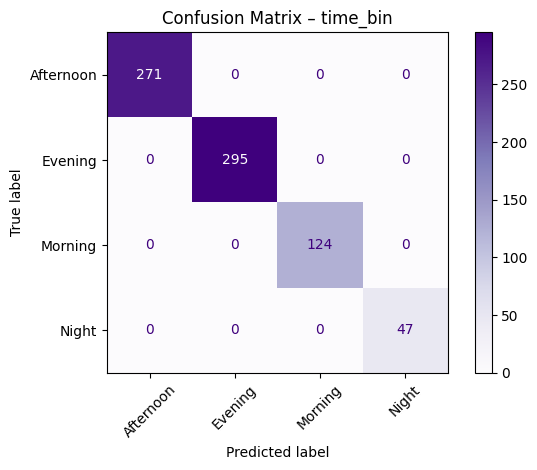

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare fresh DataFrame
ml_df = df.copy()

# Ensure time_bin exists
def time_bin(hour):
    if 6 <= hour < 12: return 'Morning'
    if 12 <= hour < 18: return 'Afternoon'
    if 18 <= hour < 24: return 'Evening'
    return 'Night'
ml_df['time_bin'] = ml_df['timestamp'].dt.hour.map(time_bin)

# Feature engineering
ml_df['hour']      = ml_df['timestamp'].dt.hour
ml_df['DayNum']    = ml_df['timestamp'].dt.dayofweek
ml_df['IsWeekend'] = ml_df['DayNum'].isin([5,6]).astype(int)
ml_df['MonthNum']  = ml_df['timestamp'].dt.month

# Feature matrix and target
X = ml_df[['hour','DayNum','IsWeekend','MonthNum']]
y = ml_df['time_bin']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing: scale numeric features, one-hot encode IsWeekend
num_feats = ['hour','DayNum','MonthNum']
cat_feats = ['IsWeekend']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
])

# Pipeline: preprocessing + classifier
pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train & predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluation
print("Classification Report – Predicting time_bin")
print(classification_report(y_test, y_pred))

# Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, cmap='Purples', xticks_rotation=45
)
plt.title('Confusion Matrix – time_bin')
plt.tight_layout()
plt.show()


Machine Learning – Classification of day_of_week


Classification Report – Predicting day_of_week
              precision    recall  f1-score   support

      Friday       0.37      0.32      0.35       102
      Monday       0.37      0.44      0.40       119
    Saturday       0.64      0.63      0.63       126
      Sunday       0.68      0.69      0.68       142
    Thursday       0.26      0.21      0.23        68
     Tuesday       0.29      0.32      0.30        87
   Wednesday       0.37      0.35      0.36        93

    accuracy                           0.46       737
   macro avg       0.43      0.42      0.42       737
weighted avg       0.46      0.46      0.46       737



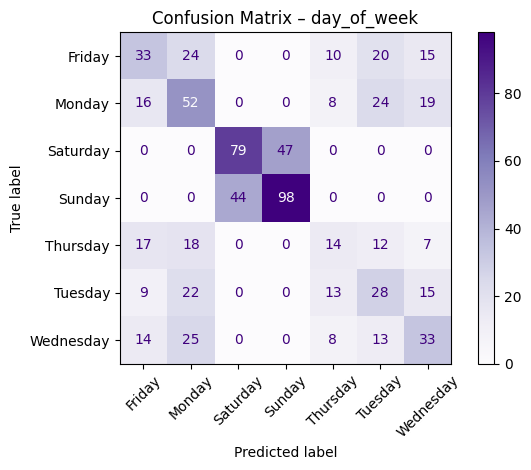

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare DataFrame
ml_df = df.copy()

# Feature engineering
ml_df['hour']      = ml_df['timestamp'].dt.hour
ml_df['DayNum']    = ml_df['timestamp'].dt.dayofweek
ml_df['IsWeekend'] = ml_df['DayNum'].isin([5,6]).astype(int)
ml_df['MonthNum']  = ml_df['timestamp'].dt.month

# Feature matrix and target
X = ml_df[['hour','IsWeekend','MonthNum']]
y = ml_df['day_of_week']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing: scale numeric, one-hot encode IsWeekend
num_feats = ['hour','MonthNum']
cat_feats = ['IsWeekend']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
])

# Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train & evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report – Predicting day_of_week")
print(classification_report(y_test, y_pred))

# Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, cmap='Purples', xticks_rotation=45
)
plt.title('Confusion Matrix – day_of_week')
plt.tight_layout()
plt.show()


Machine Learning – Regression of Daily Views


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Build daily DataFrame
daily = (
    df_clean
    .assign(
        DateOnly = df['timestamp'].dt.date,
        DayNum   = df['timestamp'].dt.dayofweek,
        IsWeekend= lambda d: d['DayNum'].isin([5,6]).astype(int),
        MonthNum = df['timestamp'].dt.month
    )
    .groupby('DateOnly')
    .agg(
        ViewsPerDay=('Series','count'),
        DayNum=('DayNum','first'),
        IsWeekend=('IsWeekend','first'),
        MonthNum=('MonthNum','first')
    )
    .reset_index(drop=True)
)

# Features and target
X = daily[['DayNum','IsWeekend','MonthNum']]
y = daily['ViewsPerDay']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing
num_feats = ['DayNum']
cat_feats = ['IsWeekend','MonthNum']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
])

# Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('reg', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Train & predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Regression Results – Predicting Daily Views")
print(f"MAE: {mae:.2f}, R²: {r2:.3f}")


Regression Results – Predicting Daily Views
MAE: 6.04, R²: -0.250
